## Dependencias

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from datetime import date,time,datetime
from dateutil.relativedelta import relativedelta as rd

from sqlalchemy.engine import create_engine
from sqlalchemy.types import BIGINT,INT,VARCHAR,CHAR,BLOB,DATE,DATETIME,NUMERIC,FLOAT,TEXT,BOOLEAN

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer

from varclushi import VarClusHi
from scipy import stats

from functools import reduce

import json 
import glob 
import os

from multiprocessing import Pool

pd.set_option('display.max_columns',None)
pd.set_option('display.float_format',lambda x:'%.2f'%x)

cf.go_offline()

In [12]:
def make_pool(func, params, threads):
    """
    Ejecuta de forma paralela múltiples llamadas a una función
    :param func: function, objeto función a paralelizar
    :param params: iterable, parámetros de evaluación paralela
    :param threads: int, número de hilos de multiprocesamiento
    :return: list, resultado de la ejecución paralela agrupada en una lista
    """
    pool = Pool(threads)
    data = pool.starmap(func, params)
    pool.close()
    pool.join()
    del pool
    return [x for x in data]

## Conexión Base de Datos

In [ ]:
creds = json.load(open('creds.json','rb'))
cnx = create_engine(f'mysql+pymysql://{creds["u"]}:{creds["p"]}@{creds["h"]}/{creds["d"]}').connect()
cnx.closed

## Lectura de datos y preparación universo inicial

In [ ]:
query = """
    SELECT 
        A.id_txn,
        A.id_user,
        A.amount,
        A.rej_reason,
        A.txn_type,
        A.is_fraud,
        A.ts,
        B.territory,
        B.mcc,
        C.gender,
        C.state,
        C.dob,
        D.card_brand,
        D.card_type,
        D.acct_open_date
    FROM
        tbl_txn A
            INNER JOIN
        tbl_merchant B USING (id_merchant)
            INNER JOIN
        tbl_user C USING (id_user)
            INNER JOIN
        tbl_card D USING (pan)
    ;
    """

In [ ]:
"""Cargamos en python la información obtenida de la conexion con sql"""
df = pd.read_sql(con=cnx,sql=query)

## Ingeniería de características

In [79]:
#Fijamos una semilla para replicar resultados
rs = np.random.RandomState(seed=20221015)

In [2]:
"""Como la carga de la informacion es tardada una vez obtenida se guarda en un pickle"""
#df.to_pickle('txn.pkl')
df = pd.read_pickle('txn.pkl')

In [4]:
"""Dividimos la base en los que son fraudes y los que no son fraudes"""
nof,f = [d.reset_index(drop=True) for _,d in df.groupby('is_fraud')]

In [5]:
"""Obtenemos una muestra de 2000 elementos que son fraudes y 2000 que no son fraudes para tener la clase balanceada"""
nof = nof.sample(n=2000,random_state=rs).reset_index(drop=True)
f = f.sample(n=2000,random_state=rs).reset_index(drop=True)

In [6]:
"""Las dos muestras se juntan en un solo dataframe"""
muestra = pd.concat([nof,f],ignore_index=True)

In [7]:
"""De la variable ts extraemos información importante con la que podamos identificar patrones"""
muestra['hora'] = muestra['ts'].map(lambda x:x.hour)
muestra['mes'] = muestra['ts'].map(lambda x:x.month)
muestra['diasem'] = muestra['ts'].map(lambda x:x.weekday()).map(dict(zip(range(7),'LMXJVSD')))

In [8]:
"""Creamos nuevas variables, con conversion a años usando el time delta"""
muestra['edad_usuario'] = np.round((muestra['ts'].dt.date-muestra['dob'])/np.timedelta64(1,'Y'),1) # del dia del movimiento se resta la fecha de cumpleaños para saber su edad
muestra['antig_cta'] = np.round((muestra['ts'].dt.date-muestra['acct_open_date'])/np.timedelta64(1,'Y'),1) #del movimiento se resta la fecha de apertura de la cuenta

In [9]:

"""Funcuon con la que creamos nuestras variables nuevas"""
usuario = 262
ancla = datetime(2014,2,9,7,57)

def caract_pasado(usuario:int,ancla:datetime)->tuple:
    ancla = pd.to_datetime(ancla)
    aux = df.loc[(df['id_user']==usuario)&((df['ts']>=(ancla+rd(days=-30)))&(df['ts']<ancla))].copy().reset_index(drop=True)
    aux['hora'] = aux['ts'].map(lambda x:x.hour)
    aux['diasem'] = aux['ts'].map(lambda x:x.weekday())
    horas_freq = "|".join(map(str,sorted(aux['hora'].value_counts().head(3).index)))
    dias_freq  = "|".join(aux['diasem'].value_counts().head(3).sort_index().index.map(dict(zip(range(7),'LMXJVSD'))))
    tiempo_desde_ult_txn = (ancla-aux['ts'].max())/np.timedelta64(1,'s')
    monto_ult_txn = aux.loc[aux['ts']==aux['ts'].max()]['amount'].max()
    monto_prom = aux['amount'].mean()
    num_op = aux.shape[0]
    monto_prom_anio_pasado = df.loc[(df['id_user']==usuario)&((df['ts']>=(ancla+rd(years=-1,days=-30)))&(df['ts']<=ancla+rd(years=-1)))].copy().reset_index(drop=True)['amount'].mean()
    return horas_freq,dias_freq,tiempo_desde_ult_txn,monto_ult_txn,monto_prom,num_op,monto_prom_anio_pasado

In [10]:
caract_pasado(usuario,ancla) #corroboramos que funcione la funcion

('7|15|18', 'M|J|S', 1080.0, 66.0, 17.139908536585363, 328, 18.505357142857143)

In [18]:
"""Damos el nombre de las nuevas variables"""
nuevas_var = ['horas_frec','dias_frec','tiempo_desde_ult_txn',
'monto_ult_txn','monto_prom_ult_mes','num_txn_ult_mes','monto_prom_anio_pasado']
#muestra ['vector'] = np.vectorize(caract_pasado)(muestra['id_user'],muestra['ts'])

In [13]:
"""Ejecutamos las dos funciones de manera simultanea, con un hilo de 100 operaciones al mismo tiempo"""
vectores = make_pool(caract_pasado,[(u,a) for u,a in zip(muestra['id_user'],muestra['ts'])],100)

In [15]:
"""Guardamos el una columna cada vector"""
muestra['vector'] = vectores

In [19]:
"""Convertimos cada elemento del vector en una serie y cada componente se adigna a cada una de las nuevas variables
nombradas anteriormente"""
muestra[nuevas_var] = muestra['vector'].apply(pd.Series)

In [21]:
"""Eliminamos la columna del vector"""
muestra.drop('vector',axis=1,inplace=True)

In [31]:
"""Identificamos si la transaccion se hizo en el mismo estado, y eso se convierte en str"""
muestra['dif_estado'] = (muestra['territory']!=muestra['state']).astype(str)

In [86]:
"""Guardamos la tabla de muestra y la leemos"""
#muestra.to_pickle('muestra.pkl')
muestra = pd.read_pickle('muestra.pkl')

In [87]:
"""Dimensiones de nuestra TAD"""
muestra.shape

(4000, 28)

In [88]:
muestra.head(2)

,id_txn,amount,rej_reason,txn_type,is_fraud,ts,territory,mcc,gender,state,dob,card_brand,card_type,acct_open_date,id_user,hora,mes,diasem,edad_usuario,antig_cta,horas_frec,dias_frec,tiempo_desde_ult_txn,monto_ult_txn,monto_prom_ult_mes,num_txn_ult_mes,monto_prom_anio_pasado,dif_estado
0,12060187,44.91,None,S,0,2001-06-02 22:08:00,CA,5211,F,CA,1964-12-01,V,D,1999-07-01,956,22,6,S,36.50,1.90,10|17|21,L|S|D,6180.00,36.99,40.19,69,39.88,False
1,6325687,24.35,None,S,0,2009-03-27 14:19:00,MI,5813,M,MI,1980-10-01,V,D,2008-09-01,633,14,3,V,28.50,0.60,7|14|16,L|J|D,22320.00,24.49,34.63,57,NaN,False


## Caracterización de variables

In [89]:
muestra.columns

Index(['id_txn', 'amount', 'rej_reason', 'txn_type', 'is_fraud', 'ts',
       'territory', 'mcc', 'gender', 'state', 'dob', 'card_brand', 'card_type',
       'acct_open_date', 'id_user', 'hora', 'mes', 'diasem', 'edad_usuario',
       'antig_cta', 'horas_frec', 'dias_frec', 'tiempo_desde_ult_txn',
       'monto_ult_txn', 'monto_prom_ult_mes', 'num_txn_ult_mes',
       'monto_prom_anio_pasado', 'dif_estado'],
      dtype='object')

In [90]:
"""Agrupamos las variables de acuerdo a su tipo"""
um = ['id_txn']
varc = ['amount','edad_usuario','antig_cta','tiempo_desde_ult_txn',
       'monto_ult_txn', 'monto_prom_ult_mes', 'num_txn_ult_mes','monto_prom_anio_pasado']
vard = ['rej_reason','txn_type','hora', 'mes', 'diasem','horas_frec', 'dias_frec','dif_estado']
vart = ['is_fraud']

In [91]:
"""Creamos un nuevo df para operar"""
df = muestra[um+vart+vard+varc]

In [92]:
df.head()

,id_txn,is_fraud,rej_reason,txn_type,hora,mes,diasem,horas_frec,dias_frec,dif_estado,amount,edad_usuario,antig_cta,tiempo_desde_ult_txn,monto_ult_txn,monto_prom_ult_mes,num_txn_ult_mes,monto_prom_anio_pasado
0,12060187,0,None,S,22,6,S,10|17|21,L|S|D,False,44.91,36.50,1.90,6180.00,36.99,40.19,69,39.88
1,6325687,0,None,S,14,3,V,7|14|16,L|J|D,False,24.35,28.50,0.60,22320.00,24.49,34.63,57,NaN
2,19414350,0,None,S,14,2,D,0|11|12,M|J|V,False,43.87,25.30,2.20,48600.00,65.36,38.35,87,48.00
3,7741346,0,None,S,16,10,V,7|8|16,V|S|D,False,45.34,25.90,5.70,93240.00,44.36,21.32,28,22.70
4,8688631,0,None,C,11,9,S,7|11|12,L|V|D,False,55.12,39.80,14.50,2160.00,10.24,38.48,83,33.43


## Partición

In [93]:
"""Dividimos el dataset en conjunto de entrenamiento y prueba"""
train,valid = train_test_split(df,train_size=0.7,random_state=rs)

In [94]:
"""Reseteamos indices"""
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)

In [95]:
"""Vemos su dimensiones"""
train.shape,valid.shape

((2800, 18), (1200, 18))

## Análisis Exploratorio de Datos

### Continuo

In [96]:
"""Para la variables agrupadas como continuas las hacemos numericas"""
for v in varc:
    train[v] = pd.to_numeric(train[v],errors='coerce')

#### Ausentes

In [97]:
"""Creamos una tabla para identificar el numero de datos ausented"""
miss = 1-train[varc].describe().T/len(train)
miss.sort_values(by='count',ascending=False,inplace=True)
miss

,count,mean,std,min,25%,50%,75%,max
monto_prom_anio_pasado,0.06,0.98,0.98,1.00,0.99,0.99,0.98,0.56
amount,0.00,0.98,0.96,1.17,1.00,0.98,0.97,0.56
edad_usuario,0.00,0.98,0.99,0.99,0.99,0.98,0.98,0.96
antig_cta,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99
tiempo_desde_ult_txn,0.00,-9.77,-13.72,0.98,-0.16,-3.59,-15.51,-162.16
monto_ult_txn,0.00,0.98,0.97,1.17,1.00,0.99,0.97,0.51
monto_prom_ult_mes,0.00,0.98,0.99,1.00,0.99,0.99,0.98,0.95
num_txn_ult_mes,0.00,0.97,0.98,1.00,0.98,0.97,0.96,0.85


In [98]:
"""Hacemos una imputacion de valores ausentes tomando como estrategia la media por si hay valores atipicos"""
im = SimpleImputer(strategy='median')
im.fit(train[varc])
Xi = pd.DataFrame(im.transform(train[varc]),columns=varc)
Xi.dropna().shape,Xi.shape

((2800, 8), (2800, 8))

In [99]:
"""Hacemos una prueba de bondad de ajuste para verificar que no dañamos la distribucion de la variables,
en este caso se muestra el valor del estadistico donde si es menor a .1 no hay problema"""
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(Xi[v],train[v]).statistic),varc),columns=['var','ks'])

In [100]:
ks

,var,ks
0,amount,0.00
1,edad_usuario,0.00
2,antig_cta,0.00
3,tiempo_desde_ult_txn,0.00
4,monto_ult_txn,0.00
5,monto_prom_ult_mes,0.00
6,num_txn_ult_mes,0.00
7,monto_prom_anio_pasado,0.06


#### Varianza Explicada

In [101]:
"""Segun la varianza ve,ps cuales quedaron fuera y cuales se mantienen"""
vt = VarianceThreshold()
vt.fit(Xi)
fuera = [v for v,var in zip(vt.feature_names_in_,vt.get_support()) if not var]
varc = [v for v in varc if v not in fuera]

In [102]:
varc

['amount',
 'edad_usuario',
 'antig_cta',
 'tiempo_desde_ult_txn',
 'monto_ult_txn',
 'monto_prom_ult_mes',
 'num_txn_ult_mes',
 'monto_prom_anio_pasado']

#### Extremos

array([[<AxesSubplot: title={'center': 'amount'}>,
        <AxesSubplot: title={'center': 'edad_usuario'}>,
        <AxesSubplot: title={'center': 'antig_cta'}>],
       [<AxesSubplot: title={'center': 'tiempo_desde_ult_txn'}>,
        <AxesSubplot: title={'center': 'monto_ult_txn'}>,
        <AxesSubplot: title={'center': 'monto_prom_ult_mes'}>],
       [<AxesSubplot: title={'center': 'num_txn_ult_mes'}>,
        <AxesSubplot: title={'center': 'monto_prom_anio_pasado'}>,
        <AxesSubplot: >]], dtype=object)

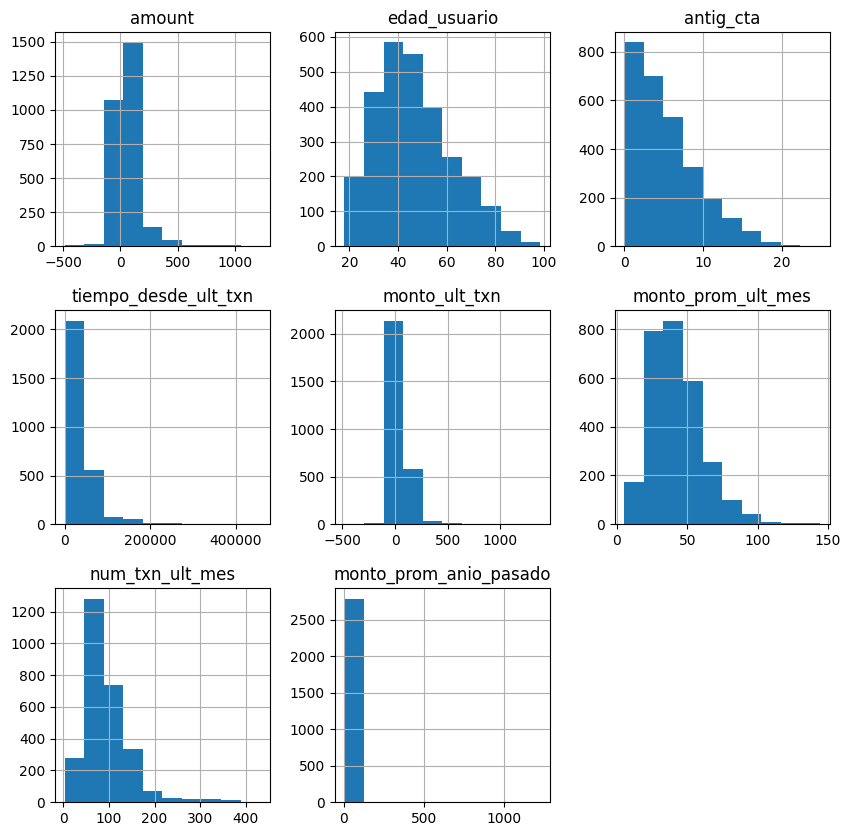

In [103]:
"""Checamos la distribucion de cada variable continua"""
Xi.hist(figsize=(10,10))

In [104]:
"""Prueba univariada por IQR"""
for v,li,ls in Xi.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values.tolist():
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex'] = Xi.filter(like='ex_').max(axis=1)

In [105]:
"""Porcentaje de eliminados"""
Xi['ex'].value_counts(1)

0   0.88
1   0.12
Name: ex, dtype: float64

In [106]:
"""Agregamos la unidad muestral para identificar a cuantos eliminados"""
Xi[um] = train[um]

In [107]:
"""Metodo multivariante, declaramos el # componentes igual a 10 por su intepretabilidad pero puede rondear por ese numero"""
gmm = GaussianMixture(n_components=10)

In [108]:
gmm.fit(Xi[varc]) #entrenamos

GaussianMixture(n_components=10)

In [109]:
Xi['ex_mv'] = gmm.predict(Xi[varc]) #predecimos

In [110]:
Xi['ex_mv'].value_counts(1) #checamos los elementos por clause y si es menor a 0.05 se dice que es outlier

0   0.21
8   0.21
5   0.18
3   0.18
1   0.07
7   0.07
2   0.06
6   0.01
4   0.01
9   0.00
Name: ex_mv, dtype: float64

array([[<AxesSubplot: title={'center': 'amount'}>,
        <AxesSubplot: title={'center': 'edad_usuario'}>,
        <AxesSubplot: title={'center': 'antig_cta'}>],
       [<AxesSubplot: title={'center': 'tiempo_desde_ult_txn'}>,
        <AxesSubplot: title={'center': 'monto_ult_txn'}>,
        <AxesSubplot: title={'center': 'monto_prom_ult_mes'}>],
       [<AxesSubplot: title={'center': 'num_txn_ult_mes'}>,
        <AxesSubplot: title={'center': 'monto_prom_anio_pasado'}>,
        <AxesSubplot: >]], dtype=object)

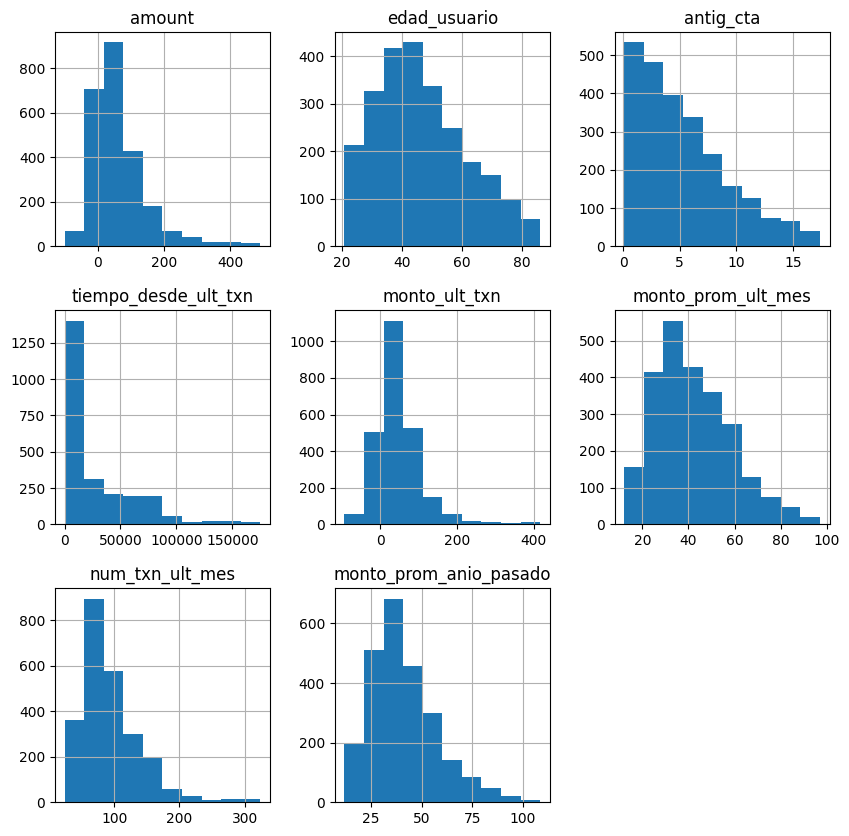

In [111]:
"""Resultados univariados"""
Xi.loc[Xi['ex']==0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[varc].hist(figsize=(10,10))

array([[<AxesSubplot: title={'center': 'amount'}>,
        <AxesSubplot: title={'center': 'edad_usuario'}>,
        <AxesSubplot: title={'center': 'antig_cta'}>],
       [<AxesSubplot: title={'center': 'tiempo_desde_ult_txn'}>,
        <AxesSubplot: title={'center': 'monto_ult_txn'}>,
        <AxesSubplot: title={'center': 'monto_prom_ult_mes'}>],
       [<AxesSubplot: title={'center': 'num_txn_ult_mes'}>,
        <AxesSubplot: title={'center': 'monto_prom_anio_pasado'}>,
        <AxesSubplot: >]], dtype=object)

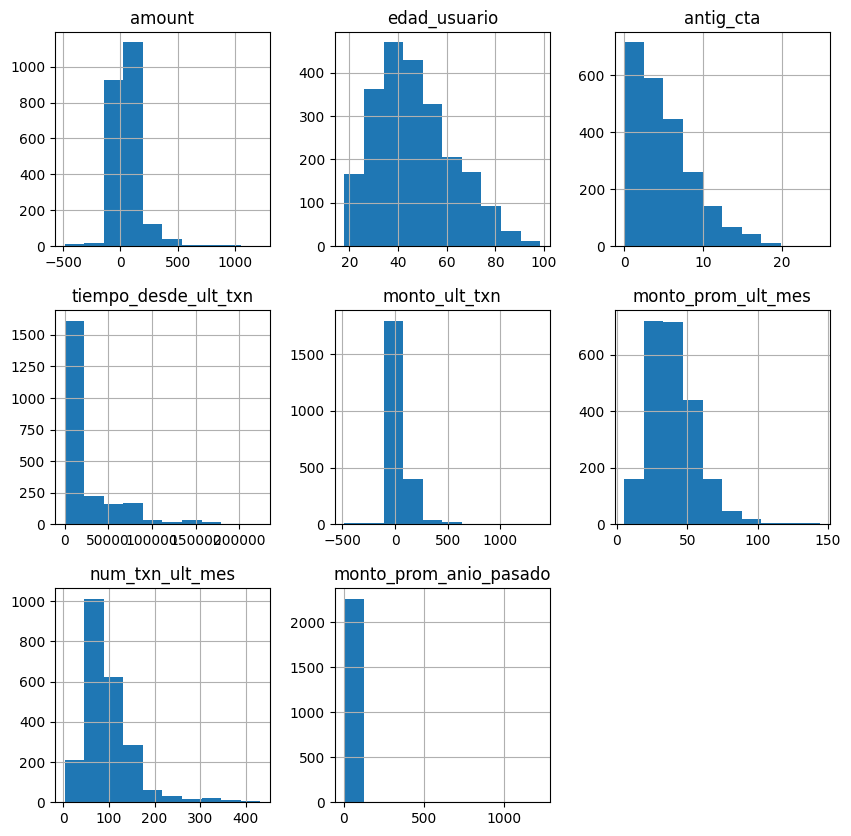

In [112]:
"""Resultados multivariados quitando los clusters 3,9,4"""
Xi.loc[~Xi['ex_mv'].isin([3,9,4])].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)[varc].hist(figsize=(10,10))

In [113]:
"""Quitamos los outliers identificados por el metodo multivariado"""
Xi = Xi.loc[~Xi['ex_mv'].isin([3,9,4])].reset_index(drop=True).drop(Xi.filter(like='ex_').columns,axis=1)

In [114]:
Xi.head()

,amount,edad_usuario,antig_cta,tiempo_desde_ult_txn,monto_ult_txn,monto_prom_ult_mes,num_txn_ult_mes,monto_prom_anio_pasado,ex,id_txn
0,97.84,44.00,9.40,16980.00,23.26,64.80,73.00,58.24,0,18182765
1,22.74,46.70,5.00,38700.00,20.53,59.92,121.00,57.57,0,21001891
2,311.83,25.20,5.40,8940.00,48.02,28.01,122.00,22.87,0,7089553
3,26.01,37.30,5.00,1860.00,18.30,35.59,157.00,39.83,0,15603055
4,-61.00,26.50,6.70,23520.00,39.56,35.17,130.00,25.65,0,7085120


#### Multicolinealidad

In [115]:
"""Usando varclushi se generan cluster de variables por su colinealidad"""
vc = VarClusHi(df=Xi,feat_list=varc)
vc.varclus()

In [116]:
vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
1,0,monto_prom_ult_mes,0.63,0.01,0.38
2,0,monto_prom_anio_pasado,0.39,0.01,0.61
0,0,monto_ult_txn,0.34,0.00,0.66
5,1,num_txn_ult_mes,0.61,0.01,0.40
4,1,tiempo_desde_ult_txn,0.56,0.00,0.44
3,1,amount,0.08,0.00,0.92
6,2,edad_usuario,0.61,0.00,0.39
7,2,antig_cta,0.61,0.01,0.40


In [117]:
"""Se toma el de menor RS_Ratop de cada cluster"""
best = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

In [118]:
best

['monto_prom_ult_mes', 'num_txn_ult_mes', 'edad_usuario']

#### Poder Predictivo

In [119]:
"""Unimos la variable objetivo"""
Xi = Xi.merge(train[um+vart],on=um,how='inner')

In [120]:
"""Aplicamos selectkbest a con numero de las variables seleccionadas por multicolinealidad"""
sk = SelectKBest(k=len(best))

In [121]:
"""Entrenamos con las variables escogidas por multicolinealidad con respecto a la target"""
sk.fit(Xi[best],Xi[vart[0]])

SelectKBest(k=3)

In [122]:
"""Visualizamos su poder predictibo"""
pd.DataFrame(zip(best,sk.scores_),
columns=['var','score']).sort_values(by='score',ascending=False).set_index('var').iplot(kind='bar',color='purple')

In [123]:
"""Removemos la de valor mas bajo"""
best.remove('monto_prom_ult_mes')

In [124]:
best #Variables continuas seleccionadas

['num_txn_ult_mes', 'edad_usuario']

array([[<AxesSubplot: title={'center': 'num_txn_ult_mes'}>,
        <AxesSubplot: title={'center': 'edad_usuario'}>]], dtype=object)

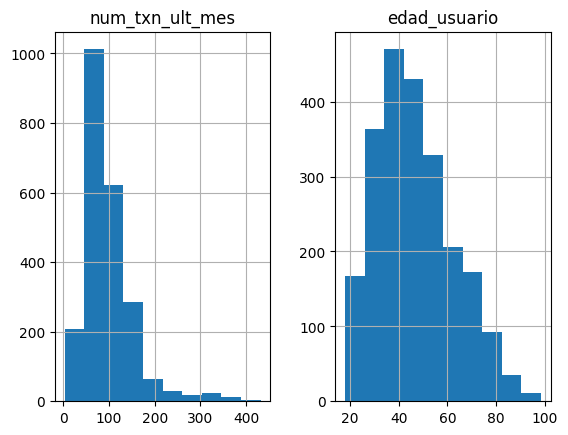

In [125]:
Xi[best].hist() #vemos sus distribucioones

#### Consideraciones Finales

In [126]:
im.fit(train[best])

SimpleImputer(strategy='median')

### Discreto

In [127]:
"""Funcion para crear la tabla de frecuencias"""
def freq(df:pd.DataFrame,var:list):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().sort_index()
        aux.columns = ['FA']
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.cumsum()
        print(f'****Tabla de frecuencias  {v}  ***\n\n')
        print(aux)
        print("\n"*3)

In [128]:
"""A los missings los mandamos a esa categoria"""
for v in vard:
    train[v] = train[v].fillna('MISSING')

In [129]:
freq(train,vard)

****Tabla de frecuencias  rej_reason  ***


                                FA   FR   FAA  FRA
Bad PIN                         31 0.01    31 0.01
Bad PIN,Insufficient Balance     3 0.00    34 0.01
Bad PIN,Technical Glitch         1 0.00    35 0.01
Insufficient Balance            29 0.01    64 0.02
MISSING                       2732 0.98  2796 1.00
Technical Glitch                 4 0.00  2800 1.00




****Tabla de frecuencias  txn_type  ***


     FA   FR   FAA  FRA
C   578 0.21   578 0.21
S  2222 0.79  2800 1.00




****Tabla de frecuencias  hora  ***


     FA   FR   FAA  FRA
0    18 0.01    18 0.01
1    10 0.00    28 0.01
2    10 0.00    38 0.01
3    18 0.01    56 0.02
4    11 0.00    67 0.02
5    25 0.01    92 0.03
6    89 0.03   181 0.06
7   181 0.06   362 0.13
8   169 0.06   531 0.19
9   236 0.08   767 0.27
10  293 0.10  1060 0.38
11  268 0.10  1328 0.47
12  251 0.09  1579 0.56
13  227 0.08  1806 0.65
14  224 0.08  2030 0.72
15  185 0.07  2215 0.79
16  161 0.06  2376 0.85
17   92

In [130]:
"""Funcion para normalizar las variables discetas"""
def normalizar(df:pd.DataFrame,var:str,umbral:float=0.05)->tuple:
    aux = df[var].value_counts(1).to_frame()
    aux['map'] = np.where(aux[var]<umbral,'Otros',aux.index)
    if aux.loc[aux['map']=='Otros'][var].sum()<umbral:
        aux['map'].replace({'Otros':aux.head(1)['map'].values[0]},inplace=True)
    aux.drop(var,axis=1,inplace=True)
    return var,aux['map'].to_dict()

In [131]:
"""Se guarda el resiltado en una lista"""
mapa_norm = list(map(lambda v:normalizar(train,v),vard))

In [132]:
"""Se crean nuevas columnas ya con la normalizacion"""
for v,mapa in mapa_norm:
    train[f'n_{v}'] = train[v].map(mapa)

In [133]:
"""Lista de variables normalizadas"""
varn = [v for v in train.columns if v[:2]=='n_']

In [134]:
"""Variables con una categoria"""
unarias = [v for v in varn if train[v].nunique()==1]
unarias

['n_rej_reason', 'n_horas_frec', 'n_dias_frec']

In [135]:
"""Quiramos las unarias"""
varn = [v for v in varn if v not in unarias]

In [136]:
"""Variables discretas seleccionadas"""
varn

['n_txn_type', 'n_hora', 'n_mes', 'n_diasem', 'n_dif_estado']

## Espacios Vectoriales a Trabajar

### Espacio $\mathcal{X}$

In [137]:
"""Unimos las variables continuas y discretas eleginas usando como llave a um"""
X = Xi[um+best].copy().merge(train[um+varn],on=um,how='inner')
X.head()

,id_txn,num_txn_ult_mes,edad_usuario,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado
0,18182765,73.00,44.00,C,14,9,D,False
1,21001891,121.00,46.70,S,7,12,D,True
2,7089553,122.00,25.20,C,15,3,M,False
3,15603055,157.00,37.30,S,7,12,M,False
4,7085120,130.00,26.50,C,Otros,6,M,False


In [138]:
"""Usamos OHE y se elimina una categoria si es binaria"""
oh = OneHotEncoder(drop='if_binary')

In [139]:
oh.fit(X[varn])

OneHotEncoder(drop='if_binary')

In [140]:
#Creamos las nuevas columnas con sus nombre signados
X[oh.get_feature_names_out()] = oh.transform(X[varn]).toarray()

In [141]:
#Eliminamos las variables anteriores, antes de los dummies
X.drop(varn,axis=1,inplace=True)

In [142]:
X.head()

,id_txn,num_txn_ult_mes,edad_usuario,n_txn_type_S,n_hora_10,n_hora_11,n_hora_12,n_hora_13,n_hora_14,n_hora_15,n_hora_16,n_hora_7,n_hora_8,n_hora_9,n_hora_Otros,n_mes_1,n_mes_10,n_mes_11,n_mes_12,n_mes_2,n_mes_3,n_mes_4,n_mes_5,n_mes_6,n_mes_7,n_mes_8,n_mes_9,n_diasem_D,n_diasem_J,n_diasem_L,n_diasem_M,n_diasem_S,n_diasem_V,n_diasem_X,n_dif_estado_True
0,18182765,73.00,44.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,21001891,121.00,46.70,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,7089553,122.00,25.20,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,15603055,157.00,37.30,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,7085120,130.00,26.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [143]:
#Agrupamos las variables a modelas para modelar
var = best+list(oh.get_feature_names_out())

### Espacio $\mathcal{X}_{[0,1]}$

In [144]:
sc01 = MinMaxScaler() #Instanciamos el escalador
sc01.fit(X[var])
X01 = pd.DataFrame(sc01.transform(X[var]),columns=var) #Creamos el dataset con los datos escalados
X01.insert(0,um[0],X[um]) #Insertamos la columna de unidad muestral

In [145]:
X01[var].describe() #validamos

,num_txn_ult_mes,edad_usuario,n_txn_type_S,n_hora_10,n_hora_11,n_hora_12,n_hora_13,n_hora_14,n_hora_15,n_hora_16,n_hora_7,n_hora_8,n_hora_9,n_hora_Otros,n_mes_1,n_mes_10,n_mes_11,n_mes_12,n_mes_2,n_mes_3,n_mes_4,n_mes_5,n_mes_6,n_mes_7,n_mes_8,n_mes_9,n_diasem_D,n_diasem_J,n_diasem_L,n_diasem_M,n_diasem_S,n_diasem_V,n_diasem_X,n_dif_estado_True
count,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00
mean,0.22,0.36,0.81,0.10,0.10,0.09,0.08,0.08,0.07,0.06,0.06,0.06,0.08,0.21,0.09,0.08,0.08,0.09,0.09,0.08,0.07,0.07,0.09,0.08,0.08,0.09,0.16,0.16,0.13,0.15,0.13,0.13,0.14,0.17
std,0.13,0.20,0.39,0.30,0.30,0.29,0.28,0.28,0.26,0.23,0.24,0.24,0.27,0.41,0.28,0.28,0.28,0.28,0.29,0.28,0.26,0.26,0.28,0.28,0.27,0.29,0.36,0.36,0.33,0.35,0.34,0.34,0.35,0.38
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,0.21,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.19,0.33,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.27,0.48,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Espacio estandarizado ($\mu=0;\sigma=1$) $\mathcal{X}_s$

In [146]:
sc = StandardScaler()
sc.fit(X[var])
Xs = pd.DataFrame(sc.transform(X[var]),columns=var) #datafram ya estandarizado
Xs.insert(0,um[0],X[um])

In [147]:
Xs.describe()

,id_txn,num_txn_ult_mes,edad_usuario,n_txn_type_S,n_hora_10,n_hora_11,n_hora_12,n_hora_13,n_hora_14,n_hora_15,n_hora_16,n_hora_7,n_hora_8,n_hora_9,n_hora_Otros,n_mes_1,n_mes_10,n_mes_11,n_mes_12,n_mes_2,n_mes_3,n_mes_4,n_mes_5,n_mes_6,n_mes_7,n_mes_8,n_mes_9,n_diasem_D,n_diasem_J,n_diasem_L,n_diasem_M,n_diasem_S,n_diasem_V,n_diasem_X,n_dif_estado_True
count,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00,2276.00
mean,10868203.63,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00
std,6500475.43,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,12978.00,-1.71,-1.83,-2.06,-0.34,-0.33,-0.31,-0.30,-0.30,-0.28,-0.25,-0.26,-0.25,-0.30,-0.51,-0.31,-0.30,-0.30,-0.31,-0.32,-0.30,-0.28,-0.28,-0.31,-0.30,-0.29,-0.31,-0.43,-0.43,-0.38,-0.42,-0.39,-0.39,-0.41,-0.45
25%,4974533.25,-0.63,-0.75,0.49,-0.34,-0.33,-0.31,-0.30,-0.30,-0.28,-0.25,-0.26,-0.25,-0.30,-0.51,-0.31,-0.30,-0.30,-0.31,-0.32,-0.30,-0.28,-0.28,-0.31,-0.30,-0.29,-0.31,-0.43,-0.43,-0.38,-0.42,-0.39,-0.39,-0.41,-0.45
50%,11088496.50,-0.25,-0.14,0.49,-0.34,-0.33,-0.31,-0.30,-0.30,-0.28,-0.25,-0.26,-0.25,-0.30,-0.51,-0.31,-0.30,-0.30,-0.31,-0.32,-0.30,-0.28,-0.28,-0.31,-0.30,-0.29,-0.31,-0.43,-0.43,-0.38,-0.42,-0.39,-0.39,-0.41,-0.45
75%,16829217.25,0.36,0.62,0.49,-0.34,-0.33,-0.31,-0.30,-0.30,-0.28,-0.25,-0.26,-0.25,-0.30,-0.51,-0.31,-0.30,-0.30,-0.31,-0.32,-0.30,-0.28,-0.28,-0.31,-0.30,-0.29,-0.31,-0.43,-0.43,-0.38,-0.42,-0.39,-0.39,-0.41,-0.45
max,21498595.00,6.04,3.28,0.49,2.97,3.00,3.18,3.31,3.33,3.61,4.01,3.86,3.95,3.34,1.96,3.20,3.32,3.31,3.26,3.17,3.29,3.61,3.62,3.21,3.31,3.39,3.19,2.32,2.31,2.64,2.41,2.53,2.54,2.44,2.21


### Espacio de componentes principales (combinación lineal ortogonal) $\mathcal{X}_p$

In [148]:
pipe_pca = make_pipeline(StandardScaler(),PCA(0.9),MinMaxScaler()) #creamos el pipline con 90% varianza explicada

In [149]:
pipe_pca.fit(X[var])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9)),
                ('minmaxscaler', MinMaxScaler())])

In [150]:
pipe_pca.steps[1][-1].explained_variance_ratio_.cumsum()

array([0.04120041, 0.08091006, 0.12059154, 0.15831795, 0.19525873,
       0.2318979 , 0.26772362, 0.30310681, 0.33779341, 0.37241364,
       0.40634094, 0.44014401, 0.47330729, 0.50617447, 0.53877369,
       0.57103744, 0.60262189, 0.63391301, 0.66512892, 0.6958412 ,
       0.72609868, 0.75562682, 0.78504476, 0.81405848, 0.84252005,
       0.87046781, 0.89812119, 0.92560213])

In [151]:
Xp = pd.DataFrame(pipe_pca.transform(X[var])) #cramos el df de pca
Xp.insert(0,um[0],X[um])

array([[<AxesSubplot: title={'center': 'id_txn'}>,
        <AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '2'}>,
        <AxesSubplot: title={'center': '3'}>],
       [<AxesSubplot: title={'center': '4'}>,
        <AxesSubplot: title={'center': '5'}>,
        <AxesSubplot: title={'center': '6'}>,
        <AxesSubplot: title={'center': '7'}>,
        <AxesSubplot: title={'center': '8'}>],
       [<AxesSubplot: title={'center': '9'}>,
        <AxesSubplot: title={'center': '10'}>,
        <AxesSubplot: title={'center': '11'}>,
        <AxesSubplot: title={'center': '12'}>,
        <AxesSubplot: title={'center': '13'}>],
       [<AxesSubplot: title={'center': '14'}>,
        <AxesSubplot: title={'center': '15'}>,
        <AxesSubplot: title={'center': '16'}>,
        <AxesSubplot: title={'center': '17'}>,
        <AxesSubplot: title={'center': '18'}>],
       [<AxesSubplot: title={'center': '19'}>,
        <AxesSu

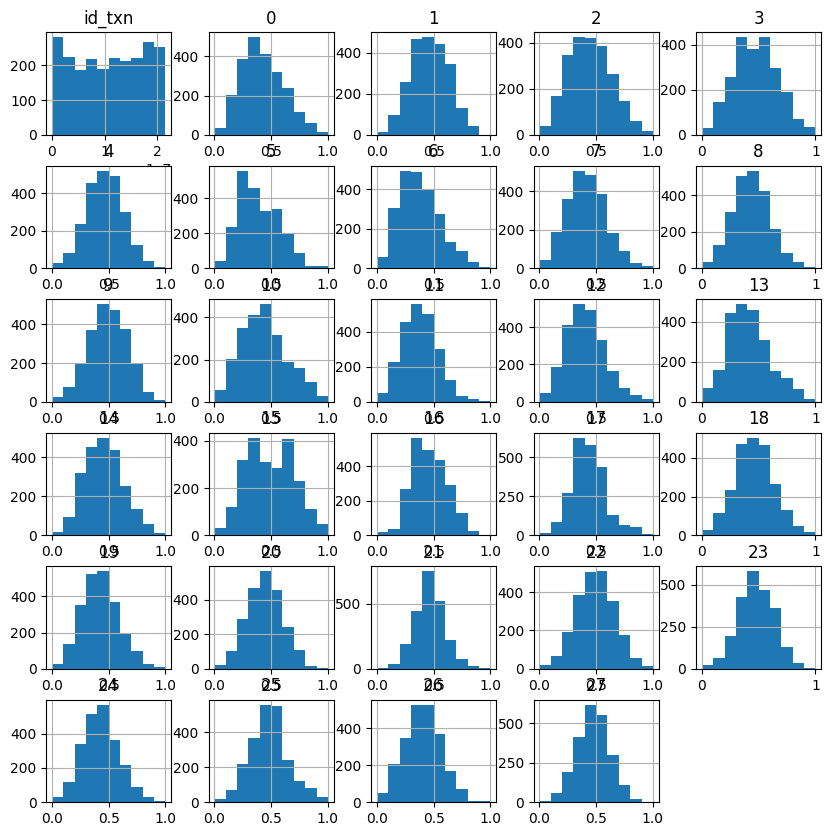

In [152]:
Xp.hist(figsize=(10,10)) #checamos las distribuciones

### Espacio Weight of Evidence (WoE) $\mathcal{X}_w$

In [153]:
Xw = Xi[um+best+vart].copy().merge(train[um+varn],on=um,how='inner') #juntamos las variables de unidad muestral,
#la target, las mejores variables continuas y las mejores variables discretas

In [154]:
Xw.head()

,id_txn,num_txn_ult_mes,edad_usuario,is_fraud,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado
0,18182765,73.00,44.00,1,C,14,9,D,False
1,21001891,121.00,46.70,1,S,7,12,D,True
2,7089553,122.00,25.20,1,C,15,3,M,False
3,15603055,157.00,37.30,0,S,7,12,M,False
4,7085120,130.00,26.50,0,C,Otros,6,M,False


#### Discretizar variables continuas

In [155]:
"""Funcion para discretizar las variables continuas"""
def discretizar(df:pd.DataFrame,v:str)->pd.DataFrame:
    aux = df[um+[v]].copy()
    l = [d for _,d in aux.groupby(aux[v].isnull())]
    if len(l)==2:
        nm,m  = l
    else:
        nm,m = l[0], l[0].loc[l[0].index==-1]
    m.reset_index(drop=True,inplace=True)
    nm.reset_index(drop=True,inplace=True)
    m[v].fillna('MISSING',inplace=True)

    kb = KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')

    kb.fit(nm[[v]])

    nm['d'] = kb.transform(nm[[v]])

    nm['d'].value_counts(1)
    mapa = nm[[v,'d']].groupby('d').agg(['min','max'])
    mapa.columns = ['min','max']
    mapa['intervalo'] = mapa.index.astype(int).map(lambda x:'%02d. '%(x+1))+mapa['min'].astype(str)+'|'+mapa['max'].astype(str)
    mapa.drop(['min','max'],axis=1,inplace=True)
    nm[v] = nm['d'].replace(mapa['intervalo'].to_dict())
    return pd.concat([nm[um+[v]],m[um+[v]]],ignore_index=True)

In [156]:
#Funcion para cruzar dos tablas con ambos codigo como full outer join
cruzar = lambda x,y:x.merge(y,on=um,how='outer')

In [157]:
#Aplicamos las dos funciones
Xwd = reduce(cruzar,map(lambda v:discretizar(Xw,v),best))

In [158]:

"""Juntamos las variables continuas discretizadas con la um, target y variables discretas normalizadas"""
Xw = Xwd.merge(Xw[um+varn+vart],on=um,how='inner')

In [159]:
Xw.head()

,id_txn,num_txn_ult_mes,edad_usuario,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado,is_fraud
0,18182765,01. 3.0|88.0,02. 34.1|50.1,C,14,9,D,False,1
1,21001891,02. 89.0|174.0,02. 34.1|50.1,S,7,12,D,True,1
2,7089553,02. 89.0|174.0,01. 18.0|34.0,C,15,3,M,False,1
3,15603055,02. 89.0|174.0,02. 34.1|50.1,S,7,12,M,False,0
4,7085120,02. 89.0|174.0,01. 18.0|34.0,C,Otros,6,M,False,0


In [160]:
"""Funcion para calcular el woe"""
def codif_woe(df:pd.DataFrame,v:str,tgt:str)->tuple:
    aux = df.pivot_table(index=v,
              columns=tgt,
              values=um[0],
              aggfunc='count',
              fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1,inplace=True)
    return v,aux['w'].to_dict()

In [161]:
"""Mapeamos los valores del woe a las variables discretas para convertirlas en continuas"""
mapa_woe = list(map(lambda v:codif_woe(Xw,v,vart[0]),best+varn))

In [164]:
mapa_woe

[('num_txn_ult_mes',
  {'01. 3.0|88.0': -0.21199908694832262,
   '02. 89.0|174.0': 0.13446276854556835,
   '03. 175.0|255.0': 1.2533104437357885,
   '04. 264.0|345.0': 0.4814401070463157,
   '05. 352.0|432.0': 0.8236103647821663}),
 ('edad_usuario',
  {'01. 18.0|34.0': 0.17121156543315652,
   '02. 34.1|50.1': -0.022640854572747886,
   '03. 50.2|66.2': -0.043392024377521175,
   '04. 66.3|82.3': -0.19988533454846275,
   '05. 82.4|98.4': 0.1221643814075257}),
 ('n_txn_type', {'C': 0.9099704880854762, 'S': -0.20389302269037238}),
 ('n_hora',
  {'10': -0.5876776777245895,
   '11': -0.42198411423458915,
   '12': -0.37031210369026835,
   '13': -0.09133114269122355,
   '14': -0.3305717750407542,
   '15': -0.390931390893004,
   '16': 0.3536067355364305,
   '7': 0.5646707611960393,
   '8': -0.008649618240496914,
   '9': -0.1471685523760585,
   'Otros': 0.7602517847844437}),
 ('n_mes',
  {'1': 0.07476214251294196,
   '10': 0.1942176990475835,
   '11': -0.24025897544207053,
   '12': -0.44314942764

In [162]:
"""Convertimos los valores continuos en discretos"""
for v,mapa in mapa_woe:
    Xw[v] = Xw[v].map(mapa)

In [163]:
Xw.head()

,id_txn,num_txn_ult_mes,edad_usuario,n_txn_type,n_hora,n_mes,n_diasem,n_dif_estado,is_fraud
0,18182765,-0.21,-0.02,0.91,-0.33,0.33,-0.29,0.20,1
1,21001891,0.13,-0.02,-0.20,0.56,-0.44,-0.29,-1.11,1
2,7089553,0.13,0.17,0.91,-0.39,-0.12,0.11,0.20,1
3,15603055,0.13,-0.02,-0.20,0.56,-0.44,0.11,0.20,0
4,7085120,0.13,0.17,0.91,0.76,0.05,0.11,0.20,0
